# Setup

In [29]:
%pip install scikit-learn
%pip install scikit-image
%pip install matplotlib

You should consider upgrading via the '/home/letung3105/.pyenv/versions/3.8.6/envs/MIP/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/letung3105/.pyenv/versions/3.8.6/envs/MIP/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/letung3105/.pyenv/versions/3.8.6/envs/MIP/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [30]:
import os
import sys
import heapq
from enum import Enum
from collections import deque

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage.filters
import skimage.io

INPUT_DIR = "Images"

CHEST_IMAGES_RAW = [
    "Chest_UoC_pa104.img",
    "Chest_UoC_pa105.img",
    "Chest_UoC_pa115.img",
]

CHEST_IMAGES_JPG = [
    "Chest_HoanMy_96.jpg",
    "Chest_HoanMy_97.jpg",
    "Chest_HoanMy_98.jpg",
]

# Task 01

First we define a function that performs Otsu's thresholding, the grayscale histogram is computed using `numpy.histogram`. Then the gray value with the maximum between class variant is found.

In [31]:
def otsu_thresholding(image_arr):
    """
    Choose a threshold for segmentation using Otsu's algorithm,
    that maximizes the between class variance for two classes

    Parameters
    ----------
    image_arr (ndarray): The ndarray that represents the image, where dimensions == 2.

    Returns
    -------
    Gray value of the threshold.
    """
    
    max_gray_val = np.max(image)
    gray_vals_bins = np.arange(max_gray_val + 1)
    gray_vals = gray_vals_bins[:max_gray_val]
    
    hist, _ = np.histogram(image, bins = gray_vals_bins)
    probs = hist / (image_arr.shape[0] * image_arr.shape[1])
    
    max_between_class_var = 0
    threshold = 0
    for gray_val in gray_vals:
        cond_bg = gray_vals <= gray_val
        cond_fg = np.logical_not(cond_bg)
        
        prob_bg = np.sum(probs, where = cond_bg)
        prob_fg = np.sum(probs, where = cond_fg)
        if prob_bg == 0 or prob_fg == 0 or prob_bg + prob_fg != 1:
            continue
       
        scaled_gray_vals = probs * gray_vals
        scaled_gray_vals_bg = scaled_gray_vals[np.where(cond_bg)]
        scaled_gray_vals_fg = scaled_gray_vals[np.where(cond_fg)]
        
        mean_bg = np.sum(scaled_gray_vals_bg / prob_bg)
        mean_fg = np.sum(scaled_gray_vals_fg / prob_fg)
        between_class_var = prob_bg * prob_fg * (mean_bg - mean_fg) ** 2
        if between_class_var > max_between_class_var:
            max_between_class_var = between_class_var
            threshold = gray_val
            
    return threshold

We now apply the our Otsu's thresholing algorithm to the raw images. Once a threshold is found, pixels in the image with value less than the threshold will be turn off. The result of the Otsu's thresholding algorithm provided by `scikit-learn` is computed for comparison

Processing 'Chest_UoC_pa104.img'
-- Threshold (computed): 578
-- Threshold (scikit-image): 578
Processing 'Chest_UoC_pa105.img'
-- Threshold (computed): 534
-- Threshold (scikit-image): 534
Processing 'Chest_UoC_pa115.img'
-- Threshold (computed): 527
-- Threshold (scikit-image): 528


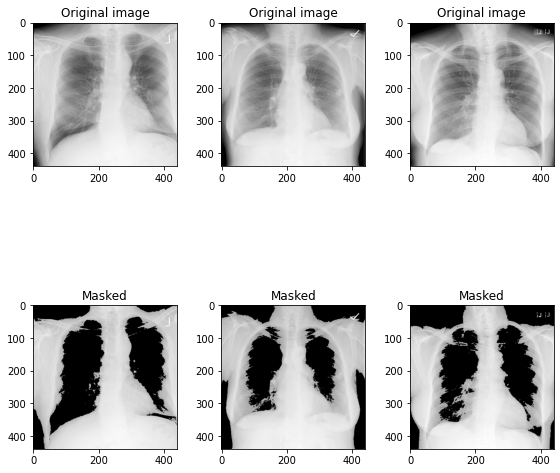

In [32]:
fig, axs = plt.subplots(2, len(CHEST_IMAGES_RAW), figsize = (8, 8))
fig.tight_layout()
for (i, img_name) in enumerate(CHEST_IMAGES_RAW):
    print("Processing '%s'" % img_name)
    image = np.memmap(
        os.path.join(INPUT_DIR, img_name),
        shape=(440, 440),
        dtype=np.uint16
    )
    image = image.byteswap()
    axs[0,i].set_title("Original image")
    axs[0,i].imshow(image, cmap = plt.cm.gray)
    
    threshold = otsu_thresholding(image)
    print("-- Threshold (computed): %d" % threshold)
    print("-- Threshold (scikit-image): %d" % skimage.filters.threshold_otsu(image))
    
    image[image < threshold] = 0
    axs[1,i].set_title("Masked")
    axs[1,i].imshow(image, cmap = plt.cm.gray)
    
plt.show()

From the results, we can see that the algorithm performs quite good on this set of images, where the lung regions are correctly segmented. Some artifacts can be found as the results from noice and the inherent limitation of the algorithm, e.g, the regions' boundaries are not clearyly defined and some part within a region is not masked correctly.

Similarly, we apply the algorithm and mask to the JPG images.

Processing 'Chest_HoanMy_96.jpg'
-- Threshold (computed): 88
-- Threshold (scikit-image): 88
Processing 'Chest_HoanMy_97.jpg'
-- Threshold (computed): 97
-- Threshold (scikit-image): 97
Processing 'Chest_HoanMy_98.jpg'
-- Threshold (computed): 97
-- Threshold (scikit-image): 97


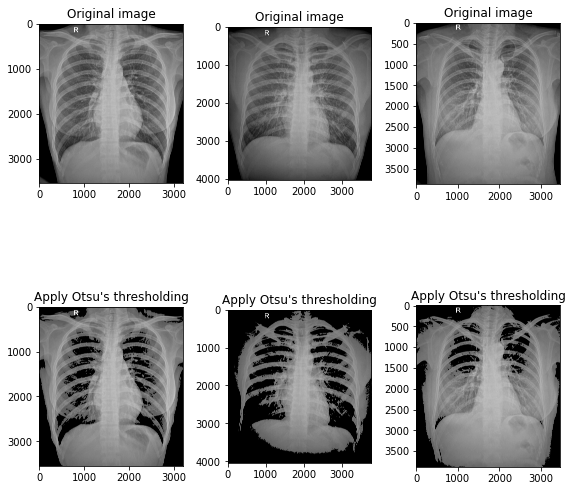

In [33]:
fig, axs = plt.subplots(2, len(CHEST_IMAGES_JPG), figsize = (8, 8))
fig.tight_layout()
for (i, img_name) in enumerate(CHEST_IMAGES_JPG):
    print("Processing '%s'" % img_name)
    image = skimage.io.imread(
        os.path.join(INPUT_DIR, img_name),
        as_gray = True,
    )
    image = np.array(
        image * np.iinfo(np.uint8).max,
        dtype = np.uint8,
    )
    axs[0,i].set_title("Original image")
    axs[0,i].imshow(image, cmap = plt.cm.gray)
    
    threshold = otsu_thresholding(image)
    print("-- Threshold (computed): %d" % threshold)
    print("-- Threshold (scikit-image): %d" % skimage.filters.threshold_otsu(image))
    
    image[image < threshold] = 0
    axs[1,i].set_title("Apply Otsu's thresholding")
    axs[1,i].imshow(image, cmap = plt.cm.gray)
    
plt.show()

With this set of images, that Otsu's thresholding algorithm performs poorly. The lung regions are not segmented correctly. With the first image and the third image, only a small region of the lung are masked by the threshold, whereas over segmentation happens with the second image.

# Task 02

## Fast-marching method with level-set fine-tuning

We define a set of helper functions that are used for the curve growing algorithms.

In [34]:
def grad(x):
    """
    Compute the gradients using Numpy and cast the resulting list into the Numpy's ndarray.
    
    Parameters
    ----------
    x (ndarray): The input multi-dimensional array.

    Returns
    -------
    The gradient value at each point of the multi-dimensional array.
    """
    
    return np.array(np.gradient(x))


def norm(x, axis=0):
    """
    Compute the Euclidean norm.
    
    Parameters
    ----------
    x (ndarray): The input multi-dimensional array.
    axis (integer): The axis along which the summation is applied.

    Returns
    -------
    The Euclidean norm for each position.
    """
    
    return np.sqrt(np.sum(np.square(x), axis=axis))


def divergence(fx, fy):
    """
    Apply the divergence operator to the vector fields.
    
    Parameters
    ----------
    fx (ndarray): The first vector field.
    fy (ndarray): The second vector field.

    Returns
    -------
    The result of the divergence operation
    """
    
    fyy, fyx = grad(fy)
    fxy, fxx = grad(fx)
    return fxx + fyy


def curvature(f):
    """
    Compute the curvature at each point on the surface.
    
    Parameters
    ----------
    f (ndarray): The input surface.

    Returns
    -------
    The curvature for every point on the surface.
    """
    
    df = grad(f)
    df_norm = norm(df)
    
    Nx, Ny = df / (df_norm + 1e-9)
    return divergence(Nx, Ny)

This functions grows the initial curve based on the gradients of the given image using the level set methods. The algorithm works as follow:
1. Compute the gradient of the image
2. For each iteration grow the curve based on the following equation
$$
\Phi = \Phi + k_1 (1 - \epsilon \kappa) |\Delta \Phi| - \beta \Delta P \cdot \Delta\Phi
$$

$$
k_1 = \frac{1}{1 + |\Delta G_\sigma * I(x, y)|}
$$

$$
P(x, y) = -|\Delta G_\sigma * I(x, y)|
$$

where,
+ $\Phi$ is the curve
+ $I(x, y)$ is the image
+ $\epsilon$ determines how much of the curve's curvature is retained
+ $\alpha$ determines the weight of the gradient, higher $\alpha$ will cause the gradients near edges to become much larger 
+ $\beta$ determines how the curve converges

In [35]:
def grow_curve_level_set_method(img, phi, dt=1, it=100, alpha=1, beta=1, epsilon=0.1):
    """
    Grow the given curve using the force that is derived from the image's gradients.

    Parameters
    ----------
    img (ndarray):
        A 2-dimensional array represents the input image.

    phi (ndarray):
        A 2-dimensional array represents the initial curve, whose shape
        is the same as the input image.

    dt (float, optional):
        Size of each time step.

    it (integer, optional):
        Number of interations.

    alpha (float, optional):
        Parameter for controlling how edges affect the curve growing force.
        
    beta (float, optional):
        Parameter for controlling how the curve converge.
        
    epsilon (float, optional):
        Parameter for controlling how the curve's curvatures at each time
        step affect the curve growing force.

    Returns
    -------
    The curve that has been evolved based on the input image's gradients.
    """

    img_grad_norm = norm(grad(img))
    g = 1.0 / (1.0 + alpha * img_grad_norm)
    for i in range(it):
        dphi = grad(phi)
        dphi_norm = norm(dphi)

        kappa = curvature(phi)
        dphi_t = (g * (1.0 - epsilon * kappa) * dphi_norm -
                  beta * np.sum(grad(-img_grad_norm) * dphi, axis = 0))
        phi = phi + dt * dphi_t

    return phi

To implement curve growing using the fast marching method, we first created a specialized priority queue that ranks the  arrival time of the pixels that are in consideration of the algorithm. The `insert` function of the priority queue will update the arrival time of an existing position if an arrival time already exists for that position and the existing arrival time is larger than the new arrival time.

In [36]:
class ArrivalTimePriorityQueue:
    """
    This class contains a heap of `(arrival_time, position)` and a matrix that contains the heap position
    of each of the positions.
    """
    def __init__(self):
        self.pq = []
        self.pq_trace = {}

    def insert(self, arrival_time, position):
        'Add a new task or update the priority of an existing task if the new priority'
        if position in self.pq_trace:
            if self.pq_trace[position][0] <= arrival_time:
                return

            self.remove(position)

        entry = [arrival_time, position]
        self.pq_trace[position] = entry
        heapq.heappush(self.pq, entry)

    def remove(self, position):
        'Mark an existing task as being removed. Raise KeyError if not found'
        entry = self.pq_trace.pop(position)
        entry[-1] = (-1, -1)

    def pop(self):
        'Remove and return the lowest priority task. Raise KeyError if empty.'
        while self.pq:
            arrival_time, position = heapq.heappop(self.pq)
            if position != (-1, -1):
                del self.pq_trace[position]
                return (arrival_time, position)

        raise KeyError("Pop from an empty queue.")

The fast marching method algorithm can now be implemented. Each pixel in the image can be in one of the following three states: *known*, *unknown*, and *neighbour*. The algorithm works as follow:
1. Take in an image and a list of seeding pixels' positions.
2. All pixels are marked as *unknown*
3. The seeding pixels are marked as *known*, and their neighbour in 4-connectivity is marked as *neighbour*
4. Calculate the arrival time for every *neighbour* pixel, and places the position of the neighbours into a priority queue where the prority is based on the calculated arrival time, where the highest priority is assigned to the position with the smallest arrival time.
5. Marked the *neighbour* pixel with the smallest arrival time as *known*
6. The neighbours in 4-connectivity of the *known* pixels, that is *unknown*, are now marked as *neighbour*.
7. Repeat the process, starting from step 4, if the number of iterations have not been reached.

In [37]:
def grow_curve_fast_marching_method(image, seeds, it=1000, alpha=1000):
    # This keeps track of the pixels in each of the sets unknown, known, and neighbour.
    # state[i,j] == -1 => pixel[i,j] belongs to the set unknown
    # state[i,j] == 0 => pixel[i,j] belongs to the set neighbour
    # state[i,j] == 1 => pixel[i,j] belongs to the set known
    ff_state = np.full(image.shape, -1)
    
    # This keeps track of the time at which the contour crosses the pixel, where T[i,j]
    # is the time when the contour crosses the pixel at position (i,j).
    # The ndarray is initialize to -1, which represents infinity, and the starting point
    # at (i,j) will have its T[i,j] = 0.
    T = np.full(image.shape, np.inf)
    
    # Deriving the curve growing force from the image's gradients
    F = np.exp(-alpha * norm(grad(image)))
    
    # Specialized priority queue for ranking possible points that can be
    # included in the curve
    PQ = ArrivalTimePriorityQueue()
    
    for seed in seeds:
        ff_state[seed] = 1
        T[seed] = 0
        for d in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            pos = (seed[0] + d[0], seed[1] + d[1])
            if pos >= (0, 0) and pos < image.shape and ff_state[pos] == -1:
                ff_state[pos] = 0

    for i in range(it):
        # Calculate the arrival time for all current neighbours.
        # + If no arrival time is associated with the neighbour, the new arrival time is added to the priority queue
        # + If an arrival time is associated with the neighbour and the new arrival tim is smaller than the existing arrival time,
        # the existing arrival time is replaced with the new arrival time
        for y_pos, x_pos in np.array(np.where(ff_state == 0)).T:
            U_h = min(
                T[y_pos - 1, x_pos] if y_pos - 1 >= 0 else np.inf,
                T[y_pos + 1, x_pos] if y_pos + 1 < image.shape[0] else np.inf,
            )
            U_v = min(
                T[y_pos, x_pos - 1] if x_pos - 1 >= 0 else np.inf,
                T[y_pos, x_pos + 1] if x_pos + 1 < image.shape[1] else np.inf,
            )

            if F[y_pos, x_pos] > np.abs(U_h - U_v):
                arrival_time = (U_h + U_v +
                                np.sqrt(2 * np.square(1 / F[y_pos, x_pos]) -
                                        np.square(U_h - U_v))) / 2
            else:
                arrival_time = np.square(1 / F[y_pos, x_pos]) + min(U_h, U_v)

            PQ.insert(arrival_time, (y_pos, x_pos))

        # Add the position with the minimum arrival to the set of known
        arrival_time, pos_new_known = PQ.pop()
        ff_state[pos_new_known] = 1
        T[pos_new_known] = arrival_time

        # Add the neighbours of the newly added position to the set of neighbours
        for d in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            pos = (pos_new_known[0] + d[0], pos_new_known[1] + d[1])
            if pos >= (0, 0) and pos < image.shape and ff_state[pos] == -1:
                ff_state[pos] = 0

    return ff_state

The curve growing algorithm using the level set method is then applied to the liver's MRI image `img0070.dcm`. The curve is grown using 6200 iterations and an alpha value of 4000, starting from the pixel position of `(100, 75)`.

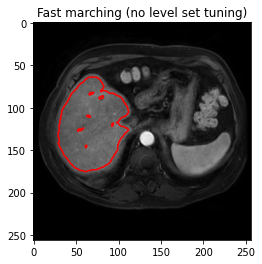

In [38]:
img_idx = 70
img = skimage.io.imread(f"{INPUT_DIR}/Liver_MRI0001/phase1/img{img_idx:04}.dcm")
img_smooth = skimage.filters.gaussian(img, 2)

phi_fm = grow_curve_fast_marching_method(img_smooth,
                                         seeds=[(100, 75)],
                                         it=6200,
                                         alpha=4000)

plt.title("Fast marching (no level set tuning)")
plt.contour(phi_fm, 0, colors="red")
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

After the fast marching method is applied, we obtained a curve that roughly resembles the shape of the liver region. To retrieve the shape of the liver, the curve is fine-tuned with the level set method for a few iterations

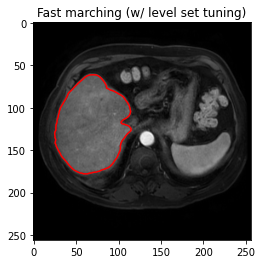

In [39]:
phi_lsm = grow_curve_level_set_method(img_smooth,
                                      phi_fm,
                                      it=30,
                                      alpha=4000,
                                      beta=1,
                                      epsilon=0.1)

plt.title("Fast marching (w/ level set tuning)")
plt.contour(phi_lsm, 0, colors="red")
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

The results of the level set method is a curve that sharply follows the boundary of the liver, and the shape of the liver can now be obtained from the curve. With different images, the iterations and seed points have to be chose manually for the algorithm to work

## Watershed segmentation

Our watershed segmentation algorithm takes in the gradients of an image and performs the following steps:
1. The gradients is sorted in ascending order.
2. The sorted gradients are divided in to a number of groupings, where each grouping contains the pixels within a range of values and the range of each grouping does not overlap.
3. Go through each level of grouping and extend a basins at each level.

The parameters `nlevels` is used to define the number of groupings, it also determines the number of flooded regions that the final segmented image has. Increase `nlevels` will result in over segmentation.

The results of the algorithms is a map of labels for each pixel in the image, these labels determines which region does the pixel of the image belongs to. In addition, the labels also identify the watershed line that separate the regions from each other.
  
*Details explainations are given as comments through out the code*

In [40]:
# ================================================================
# This code block is a modified version of the code taken from
# https://github.com/mzur/watershed
# ================================================================

def get_neighbours(height, width, pixel):
    return np.mgrid[max(0, pixel[0] - 1):min(height, pixel[0] + 2),
                    max(0, pixel[1] - 1):min(width, pixel[1] + 2)].reshape(
                        2, -1).T


def watershed_segmentation(image, nlevels=32):
    LABEL_WATERSHED = 0
    LABEL_INIT = -1
    LABEL_MASK = -2
    LABEL_QUEUED = -3

    height, width = image.shape
    total_pixels = height * width

    # Pixels' position
    pixels = np.mgrid[0:height, 0:width].reshape(2, -1).T
    # Pixels' neighbours positions
    neighbours = np.array(
        [get_neighbours(height, width, p) for p in pixels],
        dtype=np.ndarray,
    ).reshape(height, width)

    # Flatten the image
    image_flat = image.reshape(total_pixels)
    # Sort the pixels based on the pixel's value, in increasing order
    sorted_indices = np.argsort(image_flat)
    sorted_image = image_flat[sorted_indices]
    sorted_pixels = pixels[sorted_indices]
 
    current_level = 0
    level_indices = []
    # Equally divide the range from the smallest pixel's value to the largest pixel's value.
    # Then find the array indices that separate pixels in one level from pixels in another level.
    levels = np.linspace(sorted_image[0], sorted_image[-1], nlevels)
    for i in range(total_pixels):
        if sorted_image[i] > levels[current_level]:
            # Skip levels until the next highest one is reached.
            while sorted_image[i] > levels[current_level]:
                current_level += 1
            level_indices.append(i)
    level_indices.append(total_pixels)

    labels = np.full((height, width), LABEL_INIT, np.int32)
    fifo = deque()
    flag = False
    current_label = 0
    start_index = 0
    # Go through each level and flood the basin at each level
    for stop_index in level_indices:
        # Mask all pixels at the current level.
        for p in sorted_pixels[start_index:stop_index]:
            labels[p[0], p[1]] = LABEL_MASK
            # Initialize queue with neighbours of existing basins at the current level.
            for q in neighbours[p[0], p[1]]:
                if labels[q[0], q[1]] >= LABEL_WATERSHED:
                    labels[p[0], p[1]] = LABEL_QUEUED
                    fifo.append(p)
                    break

        # Extend basins.
        while fifo:
            p = fifo.popleft()
            # Label p by inspecting neighbours.
            for q in neighbours[p[0], p[1]]:
                # Don't set label_p in the outer loop because it may change.
                label_p = labels[p[0], p[1]]
                label_q = labels[q[0], q[1]]
                if label_q > 0:
                    if (label_p == LABEL_QUEUED
                            or (label_p == LABEL_WATERSHED and flag)):
                        # Flood region
                        labels[p[0], p[1]] = label_q
                    elif label_p > 0 and label_p != label_q:
                        # Two regions collide => p is a watershed
                        labels[p[0], p[1]] = LABEL_WATERSHED
                        flag = False
                elif label_q == LABEL_WATERSHED:
                    if label_p == LABEL_QUEUED:
                        # Turn into a watershed if p is enqueued to be to labeled,
                        # and p is neighboring a watershed
                        labels[p[0], p[1]] = LABEL_WATERSHED
                        flag = True # flags p to be a possible watershed
                elif label_q == LABEL_MASK:
                    # Queue q if it is a pixel belonging to the current level
                    labels[q[0], q[1]] = LABEL_QUEUED
                    fifo.append(q)

        # Detect and process new minima at the current level.
        for p in sorted_pixels[start_index:stop_index]:
            # p is inside a new minimum. Create a new label.
            if labels[p[0], p[1]] == LABEL_MASK:
                current_label += 1
                labels[p[0], p[1]] = current_label
                fifo.append(p)
                while fifo:
                    q = fifo.popleft()
                    for r in neighbours[q[0], q[1]]:
                        if labels[r[0], r[1]] == LABEL_MASK:
                            labels[r[0], r[1]] = current_label
                            fifo.append(r)

        start_index = stop_index

    return labels

A gaussian filter is applied to the liver MRI image at `img0070.dcm`, then we compute the gradients of the filtered image. The algorithm is then applied to the gradients of the image, with the parameters `nlevels` set to 16.

In [41]:
img_idx = 70
img = skimage.io.imread(f"{INPUT_DIR}/Liver_MRI0001/phase1/img{img_idx:04}.dcm")

img_smooth = skimage.filters.gaussian(img, sigma=5)
img_smooth_grad = norm(grad(img_smooth))
labels = watershed_segmentation(img_smooth_grad, nlevels=16)

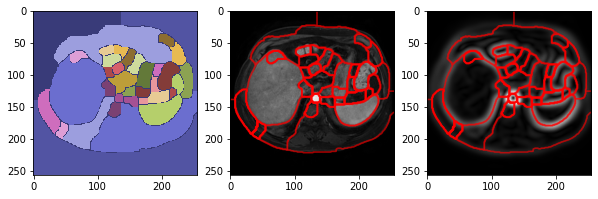

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(10, 10))

axs[0].imshow(labels, cmap=plt.cm.tab20b, interpolation="Nearest")

axs[1].imshow(img, cmap=plt.cm.gray)
axs[1].contour(labels, alpha=0.4, colors="red")

axs[2].imshow(img_smooth_grad, cmap=plt.cm.gray)
axs[2].contour(labels, alpha=0.4, colors="red")

plt.show()

From the results, we can see that the algorithm correctly labels that liver region. More important, the watershed lines correctly follows the boundary of the liver region,